In [10]:
import obspy
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import matplotlib.dates as dates
from scipy.signal import correlate
from scipy.stats.stats import pearsonr

In [3]:
in_dir = '../../data/banner/infrasound/out/'

In [73]:
l = os.listdir(in_dir)
r = []
for i in l:
    j = i[5:11]
    if j not in r:
        r.append(j)
r.sort()
dec = [i for i in r if i[2:4] == '12']
jan = [i for i in r if i[2:4] == '01']
pre_snow =[i for i in dec if int(i[-2:]) < 10]
post_snow =[i for i in dec if int(i[-2:]) > 12]
tonga = [i for i in jan if int(i[-2:]) > 14]
tonga = [i for i in tonga if int(i[-2:]) <17]
tonga = [i for i in tonga if int(i[-2:]) <16]

  0%|          | 0/1 [00:01<?, ?days/s]


NameError: name 'wl' is not defined

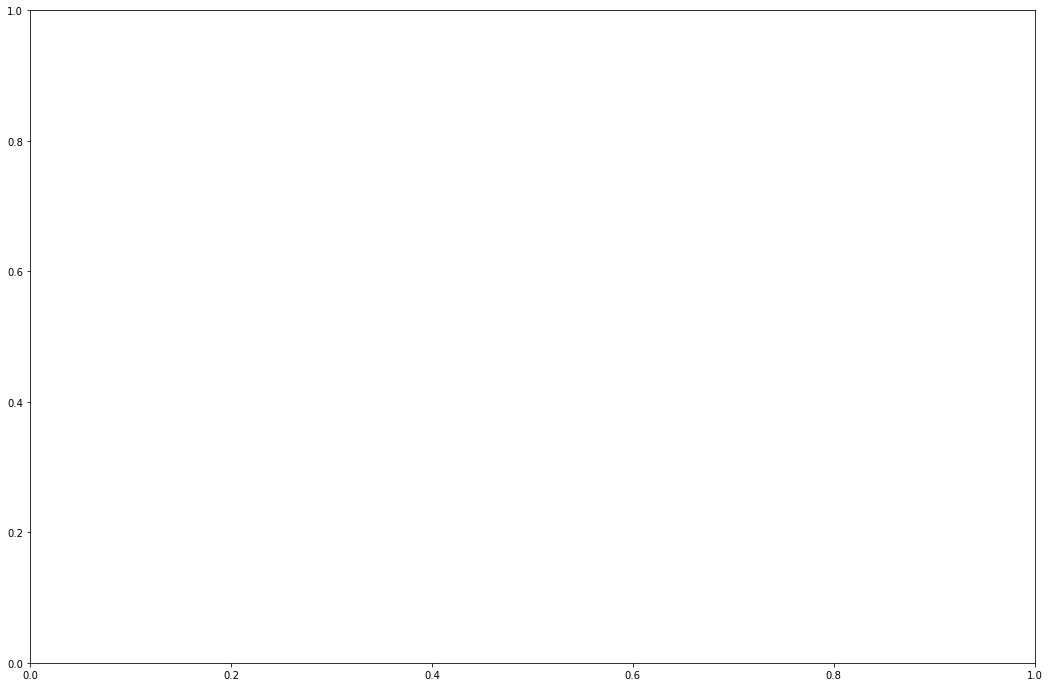

In [92]:
# a = 0
f, ax = plt.subplots(1,1, figsize = (18,12))
for d in tqdm(tonga, unit = 'days'):
    st = obspy.Stream()
    # a += 1
    # if a == 3 or a == 4:
    for i, f in enumerate(glob(os.path.join(in_dir, f'c0be4{d}*'), recursive= True)):
        st += obspy.read(os.path.join(f))
        st.detrend("constant")
        st.filter(type = 'bandpass', freqmin = 1, freqmax = 20)
    st = st.merge(method = 1)
    tr1 = st.select(channel = 'p0')[0]
    sps = tr1.__dict__['stats']['sampling_rate'] #samples per second
    wind = 10*sps #seconds of window
    ac_calib = 8.2928e-05
    #print(f'Samples per window: {wind}')
    arr1 = tr1.data * ac_calib
    if int(len(arr1)/wind) == len(arr1)/wind:
        
        tr2 = st.select(channel = 'p2')[0]
        arr2 = tr2.data * ac_calib
        arr1 = np.reshape(arr1, (int(wind),len(arr1)/wind), 'F')
        #arr2 = arr2.reshape(-1, int(wind))
        arr2 = np.reshape(arr2, (int(wind),len(arr1)/wind), 'F')

        # now compute Pearson
        xcorr0lag = np.sum(arr1*arr2, axis = 1)
        #xcorr0lag = sum(arr1*arr2)
        normalization = np.sqrt(np.sum(arr1**2, axis = 1)*np.sum(arr2**2, axis = 1))
        Pcoeff = xcorr0lag/normalization
        
        # p = a*b
        # n = np.sqrt(np.sum(a**2)*np.sum(b**2))
        # print(p/n)
        # np.mean(p/n, axis = 1)
        # # Pcoeff = np.corrcoef(arr1, arr2)

        start = pd.to_datetime(tr1.__dict__['stats']['starttime'].datetime)
        end = pd.to_datetime(tr1.__dict__['stats']['endtime'].datetime)
        t = np.linspace(start.value, end.value, len(Pcoeff))
        t = pd.to_datetime(t)
        plt.plot(t, Pcoeff, color = 'blue')
ax.xaxis.set_minor_locator(dates.HourLocator(interval=12))   # every 4 hours
ax.xaxis.set_minor_formatter(dates.DateFormatter('%H:%M'))  # hours and minutes
ax.xaxis.set_major_locator(dates.DayLocator(interval=1))    # every day
ax.xaxis.set_major_formatter(dates.DateFormatter('\n%Y-%m-%d')) 


In [90]:
a = np.array([[0,1,2,3,4],[4,5,6,7,8],[7,8,9,10,11]])
b = np.reshape(a,(5,3),'F')

In [91]:
b

array([[ 0,  8,  7],
       [ 4,  2, 10],
       [ 7,  6,  4],
       [ 1,  9,  8],
       [ 5,  3, 11]])

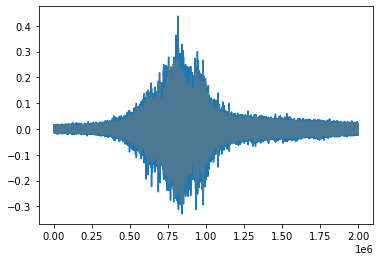

In [85]:
plt.plot(arr1.ravel()[9000000:11000000])
plt.plot(arr2.ravel()[9000000:11000000], alpha = 0.2)
plt.show()

In [39]:
a = np.array([[2,3],[4,5]])
b = np.array([[1,-1],[1,1]])
p = sum(a*b)
n = np.sqrt(np.sum(a**2)*np.sum(b**2))
print(p/n)

[ 0.40824829  0.13608276]


In [41]:
a*b

array([[ 2, -3],
       [ 4,  5]])

In [47]:
np.sum([[0, 1], [0, 5]], axis=1)

array([1, 5])

In [9]:
arr1.shape

(8640, 2000)

In [11]:
p = pearsonr(arr1, arr2)

TypeError: No loop matching the specified signature and casting was found for ufunc add

In [14]:
arr2[0:2,].shape

(2, 2000)

In [15]:
arr1[0:2,].shape

(2, 2000)

In [23]:
np.corrcoef(arr1[0:2,], arr1[0:2,])

array([[ 1.        , -0.07477702,  1.        , -0.07477702],
       [-0.07477702,  1.        , -0.07477702,  1.        ],
       [ 1.        , -0.07477702,  1.        , -0.07477702],
       [-0.07477702,  1.        , -0.07477702,  1.        ]])

In [19]:
np.corrcoef(arr1[0:2,], arr2[0:2,])

array([[ 1.        , -0.07477702, -0.05712647, -0.01234527],
       [-0.07477702,  1.        ,  0.00827963, -0.1128197 ],
       [-0.05712647,  0.00827963,  1.        , -0.01034446],
       [-0.01234527, -0.1128197 , -0.01034446,  1.        ]])

In [11]:
tr1 = st.select(channel = 'p0')[0]
sr = tr1.__dict__['stats']['sampling_rate'] #samples per second
wind = 10*sr #seconds of window
ac_calib = 8.2928e-05
print(f'Samples per window: {wind}')
assert int(len(arr1)/wind) = len(arr1)/wind
arr1 = tr1.data* ac_calib
tr2 = st.select(channel = 'p2')[0]
arr2 = tr2.data * ac_calib

SyntaxError: invalid syntax (2865112289.py, line 6)

In [17]:
# plt.plot(arr1, color = 'blue', label = 'In Snow')
# plt.plot(arr2, color = 'orange', label = 'Out of Snow', alpha = 0.3)
# plt.legend(loc = 'upper left')
# plt.show()

In [9]:
arr1 = arr1.reshape(-1, int(wind))
arr2 = arr2.reshape(-1, int(wind))

ValueError: cannot reshape array of size 122113349 into shape (2000)

In [8]:
arr1.shape

(122113349,)

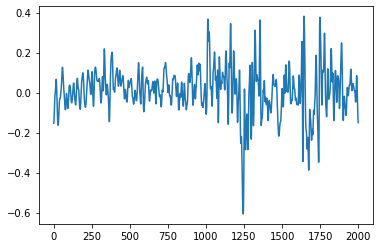

In [14]:
# now compute Pearson
xcorr0lag = sum(arr1*arr2)
normalization = np.sqrt(sum(arr1**2)*sum(arr2**2))

Pcoeff = xcorr0lag/normalization
plt.plot(Pcoeff)

In [11]:
correlate(arr1[0,:],arr2[0,:])

array([  1.31350536e-07,   1.91858834e-06,   1.37092595e-05,
         6.41880406e-05,   2.22559858e-04,   6.12163174e-04,
         1.39634038e-03,   2.72371500e-03,   4.64381145e-03,
         7.02756132e-03,   9.53367535e-03,   1.16457513e-02,
         1.27748175e-02,   1.23936547e-02,   1.01566864e-02,
         5.96735442e-03,  -2.21366569e-05,  -7.46791897e-03,
        -1.59200361e-02,  -2.49046998e-02,  -3.39812721e-02,
        -4.27688380e-02,  -5.09524855e-02,  -5.82859268e-02,
        -6.46022809e-02,  -6.98318367e-02,  -7.40118543e-02,
        -7.72669542e-02,  -7.97442530e-02,  -8.15046580e-02,
        -8.23946354e-02,  -8.19418889e-02,  -7.93245634e-02,
        -7.34514658e-02,  -6.31614172e-02,  -4.75113180e-02,
        -2.60876630e-02,   7.42383518e-04,   3.17192335e-02,
         6.47682117e-02,   9.72688751e-02,   1.26466908e-01,
         1.49937364e-01,   1.65990792e-01,   1.73927461e-01,
         1.74085462e-01,   1.67683060e-01,   1.56507482e-01,
         1.43370291e-01,

In [8]:
res = np.zeros(arr1.shape[0])
for i in tqdm(range(arr1.shape[0])):
    res[i] = correlate(arr1[i,:], arr2[i,:])

  0%|          | 0/8640 [00:00<?, ?it/s]


In [ ]:
start = pd.to_datetime(tr1.__dict__['stats']['starttime'].datetime)
end = pd.to_datetime(tr1.__dict__['stats']['endtime'].datetime)

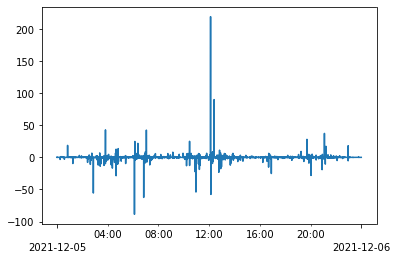

In [ ]:
import matplotlib.dates as dates
f, ax = plt.subplots(1, 1)
t = np.linspace(start.value, end.value, len(res))
t = pd.to_datetime(t)
plt.plot(t, res)
ax.xaxis.set_minor_locator(dates.HourLocator(interval=4))   # every 4 hours
ax.xaxis.set_minor_formatter(dates.DateFormatter('%H:%M'))  # hours and minutes
ax.xaxis.set_major_locator(dates.DayLocator(interval=1))    # every day
ax.xaxis.set_major_formatter(dates.DateFormatter('\n%Y-%m-%d')) 

In [ ]:
a = pd.Series(data = res, index = t)
print(a.idxmax())
a = a.reset_index()
best_index = a.idxmax()['index']

2021-12-05 12:06:55.045513984


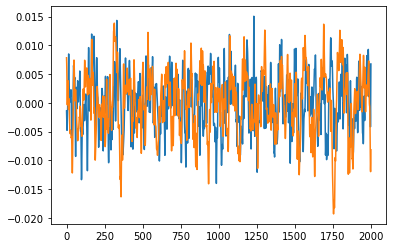

In [ ]:
plt.plot(arr1[best_index])
plt.plot(arr2[best_index])